/home/perseus/.ssh/id_ed25519

✓ SSH connected to saggitarius@100.70.234.8
Available remote datasets under /media/saggitarius/T7/position_tracking_data
1. 2025-08-17_17-08-54
2. 2025-08-18_10-09-23
3. 2025-08-18_10-10-36
4. 2025-08-18_10-21-50
5. 2025-08-18_11-04-32
6. 2025-08-18_11-50-31
7. 2025-08-18_12-02-24
8. 2025-08-18_15-06-33
9. 2025-08-18_15-57-45
10. 2025-08-21_17-48-51
11. Enter custom remote path
Enter the number of your choice: 10
Selected remote folder: /media/saggitarius/T7/position_tracking_data/2025-08-21_17-48-51

Loading sensor data...
Loading accelerometer data...
Loaded 891,631 accel1 records from accel_1_20250821_174851.bin
Loaded 891,631 accel2 records from accel_2_20250821_174851.bin
Loaded 891,631 accel3 records from accel_3_20250821_174851.bin
Loading SPI gyroscope data...
Loaded 891,631 SPI gyro records from spi_gyro_20250821_174851.bin
Loading I2C gyroscope data...
Loaded 891,631 I2C gyro records from i2c_gyro_20250821_174851.bin

Generating plots...
Sensor data plot saved to figures/2025

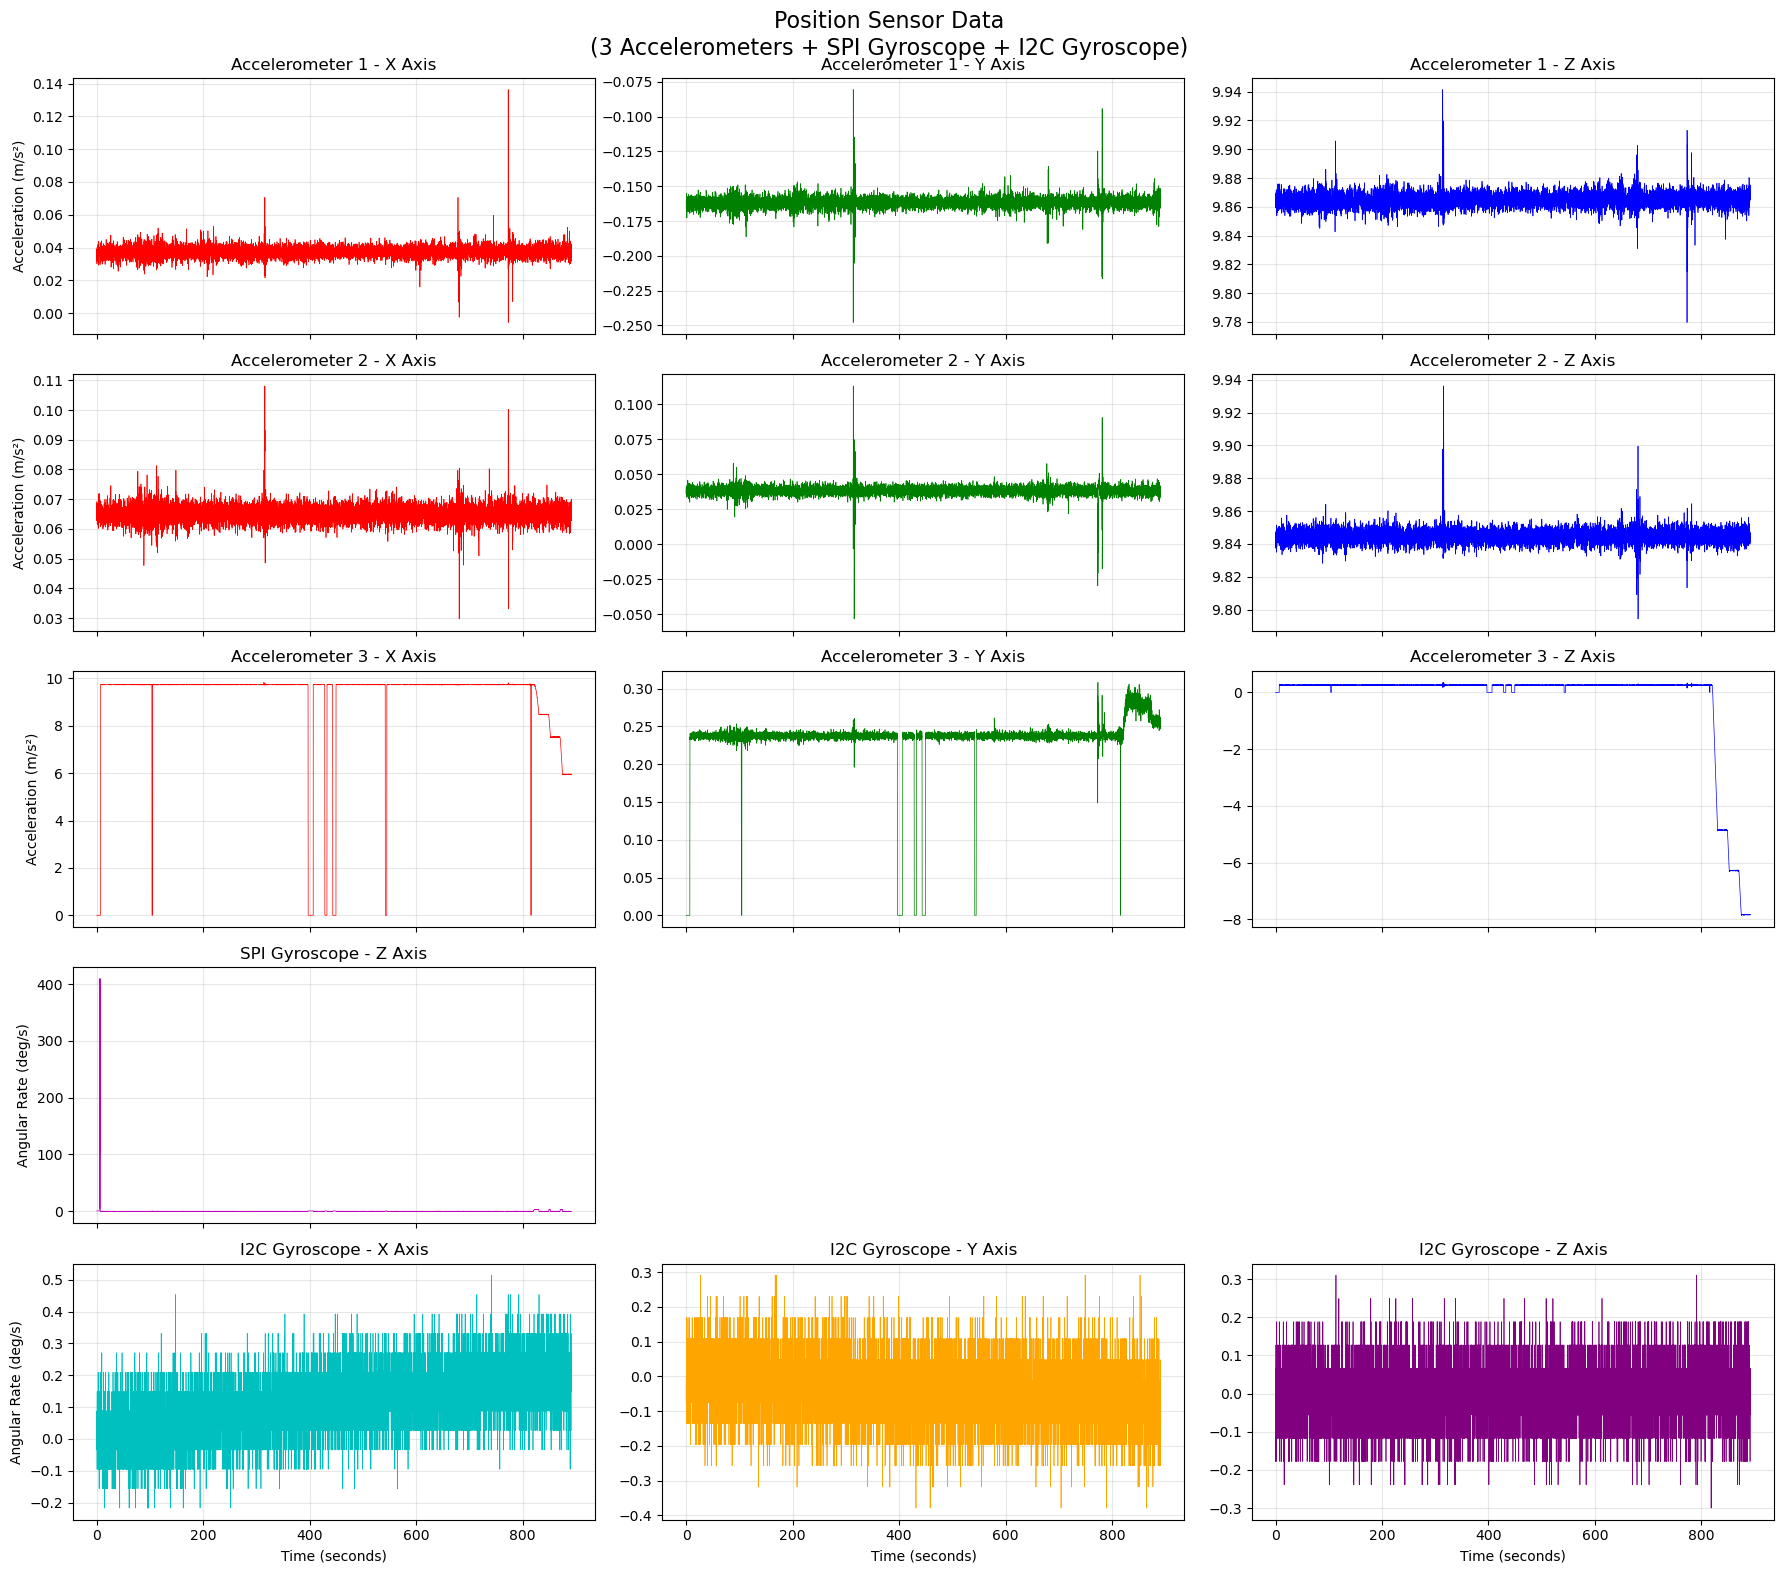

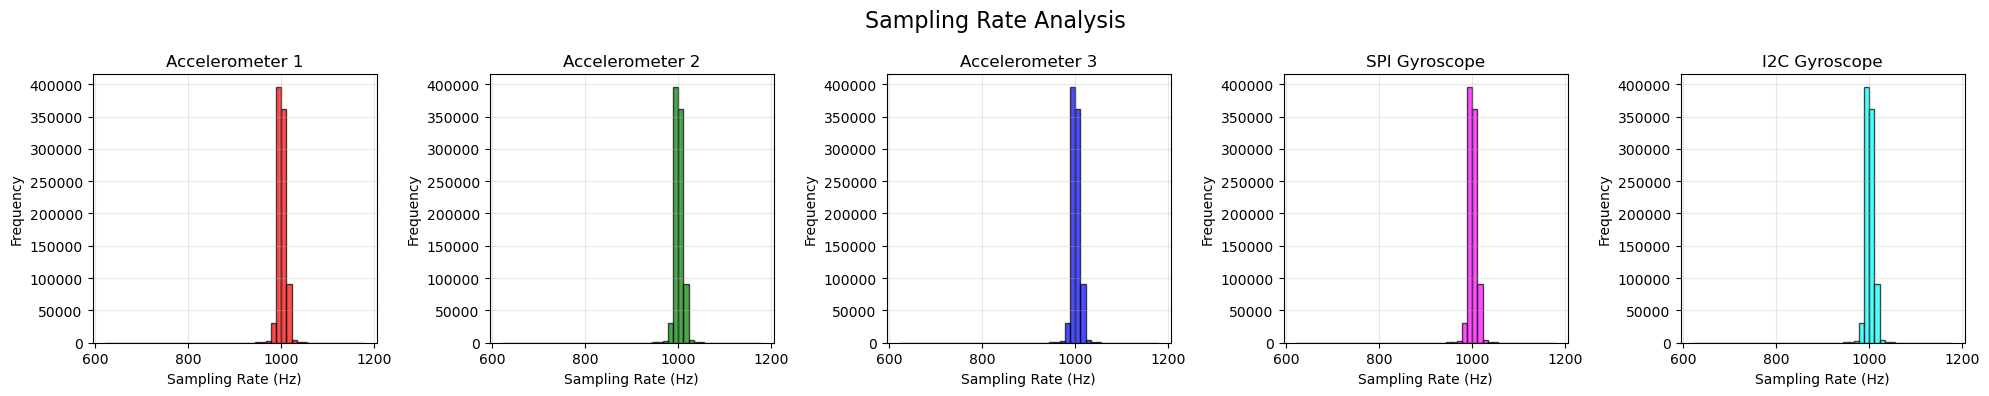


Done! Plots saved in: figures/2025-08-21_17-48-51
SSH connection closed


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import re
import struct
import time
import posixpath
import stat
import paramiko
import getpass

_TS_SCALE = {'s': 1.0, 'ms': 1e-3, 'us': 1e-6, 'ns': 1e-9}

class RemoteFS:
    """
    Minimal POSIX-like filesystem wrapper over Paramiko SFTP.
    """
    def __init__(self, host=None, username=None, password=None, port=22):
        self.host = host or os.getenv("SAG_SSH_HOST", "172.20.4.170")
        self.username = username or os.getenv("SAG_SSH_USER", "saggitarius") 
        self.password = password or os.getenv("SAG_SSH_PASS", None)
        self.port = port
        # optional key auth
        self.key_filename = os.getenv("SAG_SSH_KEY", None)
        self.passphrase = os.getenv("SAG_SSH_PASSPHRASE", None)
        self._ssh = None
        self._sftp = None

    @property
    def sftp(self):
        return self._sftp

    def connect(self, timeout=30):
        self._ssh = paramiko.SSHClient()
        self._ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())

        # Resolve key path (if provided) and ignore when missing
        keyfile = self.key_filename
        if keyfile:
            keyfile = os.path.expanduser(keyfile)
            if not os.path.exists(keyfile):
                print(f"Info: SSH key not found at {keyfile}, falling back to password/agent.")
                keyfile = None

        def _do_connect(pwd):
            self._ssh.connect(
                self.host,
                port=self.port,
                username=self.username,
                password=pwd,
                key_filename=keyfile,
                look_for_keys=True,
                allow_agent=True,
                timeout=timeout,
                auth_timeout=timeout,
                banner_timeout=timeout,
                compress=True,
            )

        try:
            # Try with provided password (or none), agent, and optional keyfile
            _do_connect(self.password)
        except FileNotFoundError:
            # Retry without keyfile if Paramiko still tried to open it
            keyfile = None
            _do_connect(self.password)
        except paramiko.AuthenticationException:
            # Prompt for password if not provided/incorrect
            if not self.password:
                self.password = getpass.getpass(f"Password for {self.username}@{self.host}: ")
            _do_connect(self.password)

        self._sftp = self._ssh.open_sftp()
        print(f"✓ SSH connected to {self.username}@{self.host}")

    def close(self):
        try:
            if self._sftp:
                self._sftp.close()
        finally:
            if self._ssh:
                self._ssh.close()
        print("SSH connection closed")

    def join(self, *parts):
        return posixpath.join(*parts)

    def listdir(self, path):
        return self._sftp.listdir(path)

    def isdir(self, path):
        try:
            st = self._sftp.stat(path)
            return stat.S_ISDIR(st.st_mode)
        except Exception:
            return False

    def open(self, path, mode='rb'):
        return self._sftp.open(path, mode)

    def getsize(self, path):
        return self._sftp.stat(path).st_size

def _detect_record_format_remote(fs: RemoteFS, remote_path, candidates, probe_records=1000):
    """
    Detect the record format using remote SFTP file.
    """
    try:
        file_size = fs.getsize(remote_path)
    except Exception:
        return candidates[0]

    viable = [c for c in candidates if (c.get('size') and file_size % c['size'] == 0 and (file_size // c['size']) >= 2)]
    if not viable:
        return candidates[0]

    now_ts = time.time()
    low_ts = now_ts - 10 * 365 * 24 * 3600.0
    high_ts = now_ts + 10 * 365 * 24 * 3600.0

    best = None
    best_score = None

    for c in viable:
        try:
            rec_size = c['size']
            ts_type, unit = c.get('ts', ('d', 's'))
            nrec = min(max(8, probe_records), file_size // rec_size)
            with fs.open(remote_path, 'rb') as f:
                buf = f.read(nrec * rec_size)
            mv = memoryview(buf)

            ts = []
            bad_ii = 0
            for i in range(nrec):
                off = i * rec_size
                if ts_type == 'II':
                    sec = struct.unpack_from('<I', mv, off)[0]
                    nsec = struct.unpack_from('<I', mv, off + 4)[0]
                    if not (low_ts <= float(sec) <= high_ts) or (nsec >= 1_000_000_000):
                        bad_ii += 1
                    t = float(sec) + float(nsec) * 1e-9
                elif ts_type == 'Q':
                    t = float(struct.unpack_from('<Q', mv, off)[0]) * _TS_SCALE.get(unit, 1.0)
                elif ts_type == 'I':
                    t = float(struct.unpack_from('<I', mv, off)[0]) * _TS_SCALE.get(unit, 1.0)
                else:  # 'd'
                    t = float(struct.unpack_from('<d', mv, off)[0])
                ts.append(t)

            ts = np.asarray(ts, dtype=float)
            diffs = np.diff(ts)
            diffs = diffs[np.isfinite(diffs)]
            if diffs.size == 0:
                continue

            med = float(np.median(diffs))
            neg = int(np.sum(diffs <= 0))
            plausible_dt = (1e-6 <= med <= 2e-2)

            ts_min = float(np.nanmin(ts))
            ts_max = float(np.nanmax(ts))
            epoch_ok = (low_ts <= ts_min <= high_ts and low_ts <= ts_max <= high_ts)

            invalid_pen = 0 if plausible_dt else 2
            epoch_pen = 0 if epoch_ok else 1
            ii_pen = bad_ii
            ts_priority = {'d': 0, 'Q': 1, 'II': 2, 'I': 3}.get(ts_type, 4)
            with np.errstate(all='ignore'):
                jitter = float(np.std(diffs))

            score = (invalid_pen, epoch_pen, ii_pen, ts_priority, neg, jitter, rec_size)
            if best_score is None or score < best_score:
                best = c
                best_score = score
        except Exception:
            continue

    return best or viable[0]

def _read_binary_records_remote(fs: RemoteFS, remote_path, fmt):
    """
    Read the entire remote binary file as fixed-size records using struct format fmt.
    Returns a list of tuples (one per record).
    """
    if not fmt.startswith(('<', '>', '!', '@', '=')):
        fmt = '<' + fmt
    rec_size = struct.calcsize(fmt)
    if rec_size <= 0:
        return []

    with fs.open(remote_path, 'rb') as f:
        data = f.read()

    rem = len(data) % rec_size
    if rem:
        data = data[:-rem]

    return list(struct.iter_unpack(fmt, data))

def _first_existing_dir(fs: RemoteFS, base: str, candidates):
    for name in candidates:
        p = fs.join(base, name)
        if fs.isdir(p):
            return p
    return None

def _dir_exists(fs: RemoteFS, base: str, name: str):
    return fs.isdir(fs.join(base, name))

def load_and_process_accelerometer_files_remote(fs: RemoteFS, folder_path):
    """
    Remote version: Load and process all .bin files for three accelerometers via SFTP.
    """
    all_data = {1: [], 2: [], 3: []}

    for accel_id in [1, 2, 3]:
        accel_folder = _first_existing_dir(
            fs, folder_path, [f'accelerometer_{accel_id}', f'accl{accel_id}']
        )
        if not accel_folder:
            print(f"Warning: Accelerometer {accel_id} folder not found")
            continue

        try:
            bin_files = sorted([fn for fn in fs.listdir(accel_folder) if fn.lower().endswith('.bin')])
        except Exception as e:
            print(f"Warning: Could not list {accel_folder}: {e}")
            continue

        if not bin_files:
            print(f"Warning: No .bin files found in {accel_folder}")
            continue

        for filename in bin_files:
            remote_file = fs.join(accel_folder, filename)
            candidates = [
                {'name': 'BCP_accel', 'size': 20, 'fmt': '<dfff', 'ts': ('d', 's')},
                {'name': 'dfff_legacy', 'size': 20, 'fmt': '<dfff', 'ts': ('d', 's')},
                {'name': 'dddd_legacy', 'size': 32, 'fmt': '<dddd', 'ts': ('d', 's')},
            ]
            chosen = _detect_record_format_remote(fs, remote_file, candidates)
            rows = _read_binary_records_remote(fs, remote_file, chosen['fmt'])
            all_data[accel_id].extend(rows)
            print(f"Loaded {len(rows):,} accel{accel_id} records from {filename}")

    dfs = {}
    for accel_id in [1, 2, 3]:
        if all_data[accel_id]:
            df = pd.DataFrame(all_data[accel_id], columns=['Timestamp', 'X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)'])
            df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s', origin='unix', errors='coerce')
            df = df.dropna(subset=['Timestamp'])
            df.set_index('Timestamp', inplace=True)
            df.sort_index(inplace=True)
            if not df.empty:
                start_time = df.index[0]
                df['Time_elapsed'] = (df.index - start_time).total_seconds()
            dfs[accel_id] = df if not df.empty else None
        else:
            dfs[accel_id] = None

    return dfs.get(1), dfs.get(2), dfs.get(3)

def load_and_process_spi_gyroscope_files_remote(fs: RemoteFS, folder_path):
    """
    Remote version: Load SPI gyro .bin files.
    """
    gyro_folder = _first_existing_dir(fs, folder_path, ['spi_gyroscope', 'gyro1'])
    if not gyro_folder:
        print(f"Warning: SPI Gyroscope folder not found")
        return None

    try:
        bin_files = sorted([fn for fn in fs.listdir(gyro_folder) if fn.lower().endswith('.bin')])
    except Exception as e:
        print(f"Warning: Could not list {gyro_folder}: {e}")
        return None

    if not bin_files:
        print("Warning: No .bin files found for SPI gyroscope")
        return None

    all_rows = []
    for filename in bin_files:
        remote_file = fs.join(gyro_folder, filename)
        candidates = [
            {'name': 'BCP_spi_gyro', 'size': 12, 'fmt': '<df', 'ts': ('d', 's')},
            {'name': 'df_legacy', 'size': 12, 'fmt': '<df', 'ts': ('d', 's')},
            {'name': 'dd_legacy', 'size': 16, 'fmt': '<dd', 'ts': ('d', 's')},
        ]
        chosen = _detect_record_format_remote(fs, remote_file, candidates)
        rows = _read_binary_records_remote(fs, remote_file, chosen['fmt'])
        all_rows.extend(rows)
        print(f"Loaded {len(rows):,} SPI gyro records from {filename}")

    if all_rows:
        df = pd.DataFrame(all_rows, columns=['Timestamp', 'Angular_Rate (deg/s)'])
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s', origin='unix', errors='coerce')
        df = df.dropna(subset=['Timestamp'])
        df.set_index('Timestamp', inplace=True)
        df.sort_index(inplace=True)
        if not df.empty:
            start_time = df.index[0]
            df['Time_elapsed'] = (df.index - start_time).total_seconds()
        return df if not df.empty else None
    return None

def load_and_process_i2c_gyroscope_files_remote(fs: RemoteFS, folder_path):
    """
    Remote version: Load I2C gyro .bin files.
    """
    gyro_folder = _first_existing_dir(fs, folder_path, ['i2c_gyroscope', 'gyro_i2c1'])
    if not gyro_folder:
        print(f"Warning: I2C Gyroscope folder not found")
        return None

    try:
        bin_files = sorted([fn for fn in fs.listdir(gyro_folder) if fn.lower().endswith('.bin')])
    except Exception as e:
        print(f"Warning: Could not list {gyro_folder}: {e}")
        return None

    if not bin_files:
        print("Warning: No .bin files found for I2C gyroscope")
        return None

    all_rows = []
    for filename in bin_files:
        remote_file = fs.join(gyro_folder, filename)
        candidates = [
            {'name': 'BCP_i2c_gyro', 'size': 24, 'fmt': '<dffff', 'ts': ('d', 's')},
            {'name': 'dffff_legacy', 'size': 24, 'fmt': '<dffff', 'ts': ('d', 's')},
            {'name': 'ddddd_legacy', 'size': 40, 'fmt': '<ddddd', 'ts': ('d', 's')},
        ]
        chosen = _detect_record_format_remote(fs, remote_file, candidates)
        rows = _read_binary_records_remote(fs, remote_file, chosen['fmt'])
        all_rows.extend(rows)
        print(f"Loaded {len(rows):,} I2C gyro records from {filename}")

    if all_rows:
        df = pd.DataFrame(all_rows, columns=['Timestamp', 'X (deg/s)', 'Y (deg/s)', 'Z (deg/s)', 'Temperature (°C)'])
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s', origin='unix', errors='coerce')
        df = df.dropna(subset=['Timestamp'])
        df.set_index('Timestamp', inplace=True)
        df.sort_index(inplace=True)
        if not df.empty:
            start_time = df.index[0]
            df['Time_elapsed'] = (df.index - start_time).total_seconds()
        return df if not df.empty else None
    return None

def select_remote_folder(fs: RemoteFS, base_path="/media/saggitarius/T7/position_tracking_data"):
    """
    Prompt user to select a dataset folder on the remote host.
    """
    try:
        candidates = sorted([d for d in fs.listdir(base_path) if fs.isdir(fs.join(base_path, d))])
    except Exception as e:
        print(f"Could not list base path {base_path}: {e}")
        candidates = []

    valid = []
    for d in candidates:
        path = fs.join(base_path, d)
        accel_set1 = all(_dir_exists(fs, path, f'accelerometer_{i}') for i in (1, 2, 3))
        accel_set2 = all(_dir_exists(fs, path, f'accl{i}') for i in (1, 2, 3))
        gyro_spi_ok = _dir_exists(fs, path, 'spi_gyroscope') or _dir_exists(fs, path, 'gyro1')
        gyro_i2c_ok = _dir_exists(fs, path, 'i2c_gyroscope') or _dir_exists(fs, path, 'gyro_i2c1')
        sub_ok = (accel_set1 or accel_set2) and gyro_spi_ok and gyro_i2c_ok
        if sub_ok:
            valid.append(d)

    print("Available remote datasets under", base_path)
    for i, d in enumerate(valid, 1):
        print(f"{i}. {d}")
    print(f"{len(valid) + 1}. Enter custom remote path")

    while True:
        try:
            choice = int(input("Enter the number of your choice: "))
            if 1 <= choice <= len(valid):
                return fs.join(base_path, valid[choice - 1]), valid[choice - 1]
            elif choice == len(valid) + 1:
                custom_path = input("Enter the custom remote path: ").strip()
                if fs.isdir(custom_path):
                    ds_name = posixpath.basename(custom_path.rstrip('/'))
                    return custom_path, ds_name
                else:
                    print("Invalid remote path. Please try again.")
            else:
                print("Invalid choice. Please try again.")
        except ValueError:
            print("Invalid input. Please enter a number.")

def plot_simple_sensor_data(accel_dfs, spi_gyro_df, i2c_gyro_df, save_dir="."):
    """
    Simple plot of all sensor data - no complications!
    """
    fig, axes = plt.subplots(5, 3, figsize=(18, 16), sharex=True)
    fig.suptitle('Position Sensor Data\n(3 Accelerometers + SPI Gyroscope + I2C Gyroscope)', fontsize=16)
    
    accel_names = ['Accelerometer 1', 'Accelerometer 2', 'Accelerometer 3']
    
    # Plot accelerometer data (first 3 rows)
    for i, (df, title) in enumerate(zip(accel_dfs, accel_names)):
        if df is not None:
            # Downsample for faster plotting if data is too large
            if len(df) > 10000:
                step = len(df) // 10000
                df_plot = df.iloc[::step]
            else:
                df_plot = df
                
            axes[i, 0].plot(df_plot['Time_elapsed'], df_plot['X (m/s^2)'], 'r-', linewidth=0.5)
            axes[i, 0].set_ylabel('Acceleration (m/s²)')
            axes[i, 0].set_title(f'{title} - X Axis')
            axes[i, 0].grid(True, alpha=0.3)
            
            axes[i, 1].plot(df_plot['Time_elapsed'], df_plot['Y (m/s^2)'], 'g-', linewidth=0.5)
            axes[i, 1].set_title(f'{title} - Y Axis')
            axes[i, 1].grid(True, alpha=0.3)
            
            axes[i, 2].plot(df_plot['Time_elapsed'], df_plot['Z (m/s^2)'], 'b-', linewidth=0.5)
            axes[i, 2].set_title(f'{title} - Z Axis')
            axes[i, 2].grid(True, alpha=0.3)
        else:
            for j in range(3):
                axes[i, j].text(0.5, 0.5, 'No Data', ha='center', va='center', transform=axes[i, j].transAxes)
                axes[i, j].set_title(f'{title} - {"XYZ"[j]} Axis')
    
    # Plot SPI gyroscope data (4th row, only first subplot)
    if spi_gyro_df is not None:
        if len(spi_gyro_df) > 10000:
            step = len(spi_gyro_df) // 10000
            spi_plot = spi_gyro_df.iloc[::step]
        else:
            spi_plot = spi_gyro_df
            
        axes[3, 0].plot(spi_plot['Time_elapsed'], spi_plot['Angular_Rate (deg/s)'], 'm-', linewidth=0.5)
        axes[3, 0].set_ylabel('Angular Rate (deg/s)')
        axes[3, 0].set_title('SPI Gyroscope - Z Axis')
        axes[3, 0].grid(True, alpha=0.3)
    else:
        axes[3, 0].text(0.5, 0.5, 'No Data', ha='center', va='center', transform=axes[3, 0].transAxes)
        axes[3, 0].set_title('SPI Gyroscope - Z Axis')
    
    axes[3, 1].set_visible(False)
    axes[3, 2].set_visible(False)
    
    # Plot I2C gyroscope data (5th row)
    if i2c_gyro_df is not None:
        if len(i2c_gyro_df) > 10000:
            step = len(i2c_gyro_df) // 10000
            i2c_plot = i2c_gyro_df.iloc[::step]
        else:
            i2c_plot = i2c_gyro_df
            
        axes[4, 0].plot(i2c_plot['Time_elapsed'], i2c_plot['X (deg/s)'], 'c-', linewidth=0.5)
        axes[4, 0].set_ylabel('Angular Rate (deg/s)')
        axes[4, 0].set_title('I2C Gyroscope - X Axis')
        axes[4, 0].grid(True, alpha=0.3)
        
        axes[4, 1].plot(i2c_plot['Time_elapsed'], i2c_plot['Y (deg/s)'], 'orange', linewidth=0.5)
        axes[4, 1].set_title('I2C Gyroscope - Y Axis')
        axes[4, 1].grid(True, alpha=0.3)
        
        axes[4, 2].plot(i2c_plot['Time_elapsed'], i2c_plot['Z (deg/s)'], 'purple', linewidth=0.5)
        axes[4, 2].set_title('I2C Gyroscope - Z Axis')
        axes[4, 2].grid(True, alpha=0.3)
    else:
        for j in range(3):
            axes[4, j].text(0.5, 0.5, 'No Data', ha='center', va='center', transform=axes[4, j].transAxes)
            axes[4, j].set_title(f'I2C Gyroscope - {"XYZ"[j]} Axis')
    
    # Set x-label for bottom row
    for j in range(3):
        if axes[4, j].get_visible():
            axes[4, j].set_xlabel('Time (seconds)')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "sensor_data.png"), dpi=150, bbox_inches='tight')
    print(f"Sensor data plot saved to {save_dir}/sensor_data.png")

def plot_sampling_rates(accel_dfs, spi_gyro_df, i2c_gyro_df, save_dir="."):
    """
    Plot sampling rate histograms for all sensors.
    """
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    fig.suptitle('Sampling Rate Analysis', fontsize=16)
    
    sensor_names = ['Accelerometer 1', 'Accelerometer 2', 'Accelerometer 3', 'SPI Gyroscope', 'I2C Gyroscope']
    all_sensors = list(accel_dfs) + [spi_gyro_df, i2c_gyro_df]
    colors = ['red', 'green', 'blue', 'magenta', 'cyan']
    
    for i, (df, sensor_name, color) in enumerate(zip(all_sensors, sensor_names, colors)):
        if df is not None and len(df) > 1:
            # Calculate sampling rate
            time_diff = df.index.to_series().diff().dt.total_seconds()
            with np.errstate(divide='ignore', invalid='ignore'):
                sampling_rate = 1.0 / time_diff
            
            # Clean up the data
            sampling_rate = sampling_rate[np.isfinite(sampling_rate)]
            sampling_rate = sampling_rate[(sampling_rate > 0) & (sampling_rate < 2000)]
            
            if len(sampling_rate) > 0:
                axes[i].hist(sampling_rate, bins=50, color=color, alpha=0.7, edgecolor='black')
                axes[i].set_title(f'{sensor_name}')
                axes[i].set_xlabel('Sampling Rate (Hz)')
                axes[i].set_ylabel('Frequency')
                axes[i].grid(True, alpha=0.3)
                
                # Print stats
                print(f"\n{sensor_name} Sampling Rate:")
                print(f"  Mean: {sampling_rate.mean():.1f} Hz")
                print(f"  Median: {sampling_rate.median():.1f} Hz")
                print(f"  Std: {sampling_rate.std():.1f} Hz")
            else:
                axes[i].text(0.5, 0.5, 'No Valid Data', ha='center', va='center', transform=axes[i].transAxes)
                axes[i].set_title(f'{sensor_name}')
        else:
            axes[i].text(0.5, 0.5, 'No Data', ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'{sensor_name}')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "sampling_rates.png"), dpi=150, bbox_inches='tight')
    print(f"Sampling rate plot saved to {save_dir}/sampling_rates.png")

def main():
    # Remote base directory with datasets
    remote_base = "/media/saggitarius/T7/position_tracking_data"

    # Connect SSH/SFTP  
    fs = RemoteFS(host=os.getenv("SAG_SSH_HOST", "100.70.234.8"),
                  username=os.getenv("SAG_SSH_USER", "saggitarius"),
                  password=os.getenv("SAG_SSH_PASS", None))
    try:
        fs.connect()
    except Exception as e:
        print(f"SSH connection failed: {e}")
        return
    
    try:
        # Select remote dataset folder
        folder_path, ds_name = select_remote_folder(fs, base_path=remote_base)
        print(f"Selected remote folder: {folder_path}")

        # Local figures dir
        figures_dir = os.path.join("figures", ds_name)
        os.makedirs(figures_dir, exist_ok=True)

        # Load all sensor data (remote)
        print("\nLoading sensor data...")
        print("Loading accelerometer data...")
        accel_df1, accel_df2, accel_df3 = load_and_process_accelerometer_files_remote(fs, folder_path)
        accel_dfs = (accel_df1, accel_df2, accel_df3)

        print("Loading SPI gyroscope data...")
        spi_gyro_df = load_and_process_spi_gyroscope_files_remote(fs, folder_path)

        print("Loading I2C gyroscope data...")
        i2c_gyro_df = load_and_process_i2c_gyroscope_files_remote(fs, folder_path)

        # Generate simple plots
        print("\nGenerating plots...")
        plot_simple_sensor_data(accel_dfs, spi_gyro_df, i2c_gyro_df, save_dir=figures_dir)
        plot_sampling_rates(accel_dfs, spi_gyro_df, i2c_gyro_df, save_dir=figures_dir)

        plt.show()

        print(f"\nDone! Plots saved in: {figures_dir}")
        
    finally:
        fs.close()

if __name__ == "__main__":
    main()